# Neural Decoding: Predicting Hand Movement from Motor Cortex Signals

## 1. Project Overview

Machine learning provides powerful tools for neuroscientists to decode how sensory and motor information is represented in the brain. Beyond advancing our scientific understanding of neural processes, effective neural decoding is foundational for brain-machine interfaces (see, e.g., https://www.youtube.com/watch?v=QRt8QCx3BCo). 

In this project, I apply model selection techniques to analyze real neural recordings and predict hand movement from neural activity. The workflow demonstrates:
 * Representation of neural time-series data using arrays
 * Loading and handling neural datasets from pickle files
 * Fitting memoryless linear models to neural data
 * Building and evaluating linear time-series models with temporal delays
 * Training linear models with multiple target outputs
 * Selecting the optimal temporal delay using cross-validation

This project highlights practical approaches for neural data analysis and model selection, with applications in neural engineering and brain-computer interface development.

### Dataset Overview: CRCNS Dream Motor Cortex Neural Recordings
This project utilizes neural recordings from the CRCNS Dream dataset, as described in:

<a href="https://pubmed.ncbi.nlm.nih.gov/21613593/">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

The dataset consists of spike counts recorded from 196 neurons in the primary motor cortex (M1) of a monkey, using an implanted electrode array. During the experiment, the monkey performed a series of reaching tasks while both neural activity and hand kinematics (position and velocity) were recorded.

The primary objective is to predict hand movement based on neural signals from the motor cortex. This type of neural decoding is foundational for brain-machine interface technologies, such as [Braingate and Neuralink](https://www.youtube.com/watch?v=QRt8QCx3BCo), which aim to translate neural activity into control signals for external devices.

The full dataset is available from the CRCNS repository (http://crcns.org/data-sets/movements/dream). For convenience and ease of use, pre-processed versions of the data are provided by the [Kording Lab](http://kordinglab.com/) at UPenn, and can be accessed via their [Neural Decoding repository](https://github.com/KordingLab/Neural_Decoding). The file `example_data_s1.pickle` used in this project is available for direct download [here](https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true).


## 2. Data Loading & Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
fn_src = 'https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true'
import os
from six.moves import urllib

data_dir = os.path.join('.', 'data')
os.makedirs(data_dir, exist_ok=True) 
fn_dst = os.path.join(data_dir, 'example_data_s1.pickle')

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File .\data\example_data_s1.pickle is already downloaded


In [3]:
# load data from pickle file
with open(fn_dst, 'rb') as fp:
    X,y = pickle.load(fp) #function reads the pickle file and deserializes the contents back into Python objects

 The matrix `X` contains spike counts, where `X[i, j]` represents the number of spikes recorded from neuron `j` during time bin `i`.
 The matrix `y` has two columns:
 * `y[i, 0]`: velocity of the monkey's hand in the x-direction
 * `y[i, 1]`: velocity of the monkey's hand in the y-direction

 In this analysis, the focus is on predicting the x-direction hand velocity (`y[i, 0]`) from the neural activity in `X`. While the methodology can be extended to both velocity components, restricting to a single direction streamlines the workflow. Accordingly, we extract the relevant column:

In [4]:
y = y[:,0] #extract only the x-direction velocity across all time bins

Each time bin represent `tsamp=0.05` seconds of time.
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `ttotal = ` total time of the experiment in seconds.

In [5]:
tsamp = 0.05  # sampling time of each time bin in seconds

nt = X.shape[0]  # each tim bin is an observation/record
nneuron = X.shape[1]   #each neuron is a different predictor variables
ttotal = nt * tsamp

print(f"Total number of time bins: {nt}")
print(f"Total number of neurons: {nneuron}")
print(f"Total time of the experiment: {ttotal:.2f}. seconds")

Total number of time bins: 61339
Total number of neurons: 52
Total time of the experiment: 3066.95. seconds


### Splitting Dataset into Train/Validation/Test Splits

I use a 2/3 training - 1/3 test split, with random indices to ensure the split is random each time the code is run and to avoid any bias in the split.

- `Xtr`, `ytr`: training data set
- `Xts`, `yts`: test data set

In [6]:
np.random.seed(2056)

rand_indices = np.random.permutation(nt) #returns a random permutation (within an ndarray) of integers (indices) from 0 to nt - 1

train_test_split_index = int(np.floor(2 * nt / 3)) # 2/3rds training and 1/3 testing

#print(rand_indices)
#print(train_test_split_index)

train_indices = rand_indices[:train_test_split_index]
test_indices = rand_indices[train_test_split_index:]

#print(train_indices.shape)
#print(test_indices.shape)

Xtr = X[train_indices, :]  # select 2/3 of the times bins randomly across all neurons
Xts = X[test_indices, :]   # select 1/3 of the time bins randomly across all neurons

ytr = y[train_indices]  # select corresponding 2/3 time bins from the x-direction velocity target value column (y is already stripped of 2nd col)
yts = y[test_indices] 

print("Number of training samples: ", Xtr.shape[0])
print("Number of neurons (features) per sample: ", Xtr.shape[1])

Number of training samples:  40892
Number of neurons (features) per sample:  52


# 3. Model Development

## Fitting a Memoryless Linear Model

First a simple, memoryless linear regression model is fit to showcase limitations of the model when temporal dependencies are not considered.



In [7]:
def fit_mult_linear(X,y):
    """
    Given matrix of predictors X and target vector y fit for a multiple linear regression model under the squared loss.
    """

    num_tr_time_bins = X.shape[0]
    ones = np.ones((num_tr_time_bins,1))
    X = np.hstack((ones, X)) #prepend the ones column vector to the X matrix to include an intercept parameter (bias term)
    
    Xt = np.transpose(X)
    beta= np.linalg.inv(Xt@X)@Xt@y  #returns optimized parameter vector minimizing the l_2 loss

    return beta

In [8]:
#fit the multiple linear regression model using the training set
optimal_beta_values = fit_mult_linear(Xtr,ytr)

#prepend ones column to Xts
ones = np.ones((Xts.shape[0], 1))
Xts = np.hstack((ones, Xts)) # hstack stacks arrays horizontally (column-wise)

y_hat = Xts@optimal_beta_values # get predicted valus using the test set

Next `yhat` and `yts` are compared to measure the **averaged squared loss** (empirical risk) on the test set.

In [13]:
test_loss = np.sum((yts - y_hat)**2)
test_empirical_risk = test_loss / len(yts)

print("The empirical risk of the test set is: ", round(test_empirical_risk, 4))


The empirical risk of the test set is:  62.134


Plot predicted values, `yhat`,  vs. true values, `yts` with a scatter plot.

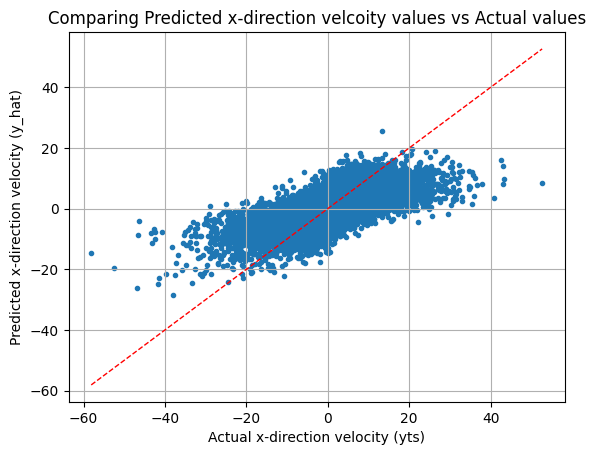

In [9]:
x_coords = np.linspace(yts.min(), yts.max(), 100) # for diagonal line
y_coords = x_coords

plt.scatter(yts, y_hat, marker='.')
plt.plot(x_coords, y_coords, 'r--', linewidth=1)
plt.grid()
plt.title("Comparing Predicted x-direction velcoity values vs Actual values")
plt.xlabel("Actual x-direction velocity (yts)")
plt.ylabel("Predicted x-direction velocity (y_hat)")
plt.show()

## Fitting a Model with Temporal Delays

To enhance model accuracy, we introduce delayed versions of the input features. The initial model implemented above is defined as:

$$
\hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0
$$

where $p$ denotes the number of features and $\beta$ represents the coefficient vector. In this "memoryless" configuration, the prediction $\hat{y}_i$ at time $i$ depends solely on the inputs $X_{i,1,\ldots,p}$ at the same time point. However, in many real-world systems, including those encountered in neuroscience, there is often a temporal delay between the input features $X_{i,1,\ldots,p}$ and the corresponding outputs $y_i$. To account for such dynamics, we adopt a model of the form:

$$
\hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} + \beta_{0,m}
$$

Here, $\beta$ is a two-dimensional array of coefficients, where $\beta_{j,m}$ quantifies the influence of the input $X_{i+m,j}$ on the output $y_{i+d}$.

This formulation is known as a *Finite Impulse Response (FIR)* filter in signal processing. The key characteristic is that the output at time $i+d$ is a function of the inputs at times $i, i+1, ..., i+d$, thereby incorporating information from the previous $d+1$ time steps, not just the most recent time.

To recast this as a linear regression problem, we construct new feature and target matrices as follows:

- $Xdly[i,:]$ is formed by concatenating the vectors $X[i,:], X[i+1,:], ..., X[i+d,:]$
- $ydly[i,:] = y[i+d,:]$

Given an input matrix $X$ of size $n \times p$, the resulting delayed feature matrix $Xdly$ will have dimensions $(n-d) \times (d+1)p$.


In [33]:
def create_dly_data(X,y,d):
    """
    Create delayed data
    """
    n, p = X.shape
    Xdly = np.zeros((n - d, (d + 1) * p))
    ydly = np.zeros((n - d))
    for i in range(n - d):
        Xdly[i, :] = np.concatenate(X[i: i + d + 1, :])  #plus 1 to include row x_i+d in each delay submatrix
        # np.concatenate combines each sample vector (row) into a single row vector
        ydly[i] = y[i + d]

    return Xdly, ydly

Below, a linear delayed model is fitted using six additional delay lags (d=6).

The delayed data are generated with `Xdly, ydly = create_dly_data(X, y, 6)`, followed by splitting into 2/3 training and 1/3 test sets.

The model is trained on the delayed training data, and the average squared loss (empirical risk) is evaluated on the test set. 

As demonstrated, incorporating temporal delays into each sample vector yields a notable improvement over the memoryless model.

In [34]:
#Create delayed data with d=6
d = 6
Xdly,ydly=create_dly_data(X,y,d)


#split delayed data into 2/3 training set and 1/3 test sets
rand_indices = np.random.permutation(nt - d) 
train_test_split_index = int(np.floor(2 * (nt - d) / 3)) # 2/3rds training and 1/3 testing

train_indices = rand_indices[:train_test_split_index]
test_indices = rand_indices[train_test_split_index:]


Xtr_dly = Xdly[train_indices, :]  # select 2/3 of the times bins randomly across all neurons
Xts_dly = Xdly[test_indices, :]   # select 1/3 of the time bins randomly across all neurons

ytr_dly = ydly[train_indices]  # select corresponding 2/3 time bins from the x-direction velocity target value column (y is already stripped of 2nd col)
yts_dly = ydly[test_indices] 

#fit the multiple linear regression model using the delayed training set
optimal_beta_values_dly = fit_mult_linear(Xtr_dly,ytr_dly)

#prepend ones column to Xts_dly
ones = np.ones((Xts_dly.shape[0], 1))
Xts_dly = np.hstack((ones, Xts_dly))
y_hat_dly = Xts_dly@optimal_beta_values_dly # get predicted valus using the delayed test set


#measure the test loss from the delayed test set
test_loss_dly = np.sum((yts_dly - y_hat_dly)**2)
test_empirical_risk_dly = test_loss_dly / len(yts_dly)

print("The empirical risk of the delayed test set is: ", round(test_empirical_risk_dly, 4))


The empirical risk of the delayed test set is:  17.5186


Plot the predicted vs. true values as before. You should visually see the improvement too.

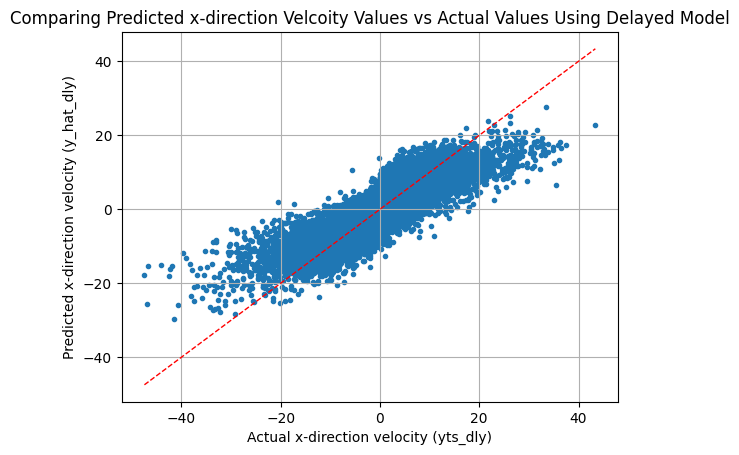

In [35]:
x_coords = np.linspace(yts_dly.min(), yts_dly.max(), 100) # for diagonal line
y_coords = x_coords

plt.scatter(yts_dly, y_hat_dly, marker='.')
plt.plot(x_coords, y_coords, 'r--', linewidth=1)
plt.grid()
plt.title("Comparing Predicted x-direction Velcoity Values vs Actual Values Using Delayed Model")
plt.xlabel("Actual x-direction velocity (yts_dly)")
plt.ylabel("Predicted x-direction velocity (y_hat_dly)")
plt.show()

The above plot visually indicates a better fit via:
* Tigther Clustering Around the Diagonal Line
    - points cluster much more tightly compared to the memoryless model
    - implies the predictions are much closer to actual values
* Reduced Spread
    - much tighter concentration of points, implying the model is more consistent and reliable
* Fewer Outliers
    - the time delay model has fewer extreme prediction errors

# 4. Selecting the Optimal Delay via Model Order Selection

Instead of using a fixed delay, `d=6`, the optimal delay is selected using model order selection.  Given the large number of data samples,the optimal model order uses a very high delay.  

A simple train-test split is used for computational efficiency.

Model orders up to `dmax=30` are considered.  In order to do this, a delayed dataset is created, `Xdly,ydly` using `create_dly_data` with `dly=dmax`. This data is split into training and test data as before, with a 2/3 -1/3 split.

In [36]:
dmax = 30


Xdly, ydly = create_dly_data(X, y, dmax)

#split delayed data into 2/3 training set and 1/3 test sets
rand_indices = np.random.permutation(nt - dmax) 
train_test_split_index = int(np.floor(2 * (nt - dmax) / 3)) # 2/3rds training and 1/3 testing

train_indices = rand_indices[:train_test_split_index]
test_indices = rand_indices[train_test_split_index:]


Xtr_dly_max = Xdly[train_indices, :]  # select 2/3 of the times bins randomly across all neurons
Xts_dly_max = Xdly[test_indices, :]   # select 1/3 of the time bins randomly across all neurons

ytr_dly_max = ydly[train_indices]  # select corresponding 2/3 time bins from the x-direction velocity target value column (y is already stripped of 2nd col)
yts_dly_max = ydly[test_indices] 

Now loop over delays from 0 to `dmax`. For each delay: train on the train set and compute the average squared loss on the test set. Store these losses in an array `losses`.

**Important Note**: for different delay values, different **subset of columns** from the `Xdly` matrix are used to save time. Its inefficient to be re-creating a new test set for each model order xperimented on.

In [37]:
test_losses = np.zeros(dmax)


for d in range(0,dmax):

    Xtr_dly_current = Xtr_dly_max[:, :((d + 1) * nneuron)]
    Xts_dly_current = Xts_dly_max[:, :((d + 1) *nneuron)]

    #train the multi regression model again on the current training data set for d
    beta_delay = fit_mult_linear(Xtr_dly_current, ytr_dly_max)

    ones_test = np.ones((Xts_dly_current.shape[0], 1))
    Xts_dly_current = np.hstack((ones_test, Xts_dly_current))

    y_hat = Xts_dly_current@beta_delay

    test_losses[d] = np.mean((yts_dly_max - y_hat) ** 2)

Plot loss vs. delay to visualize how model generalization changes with increasing complexity.

Estimated best delay is 1.450000 seconds (d = 29) with a loss = 19.848301.
(30,)


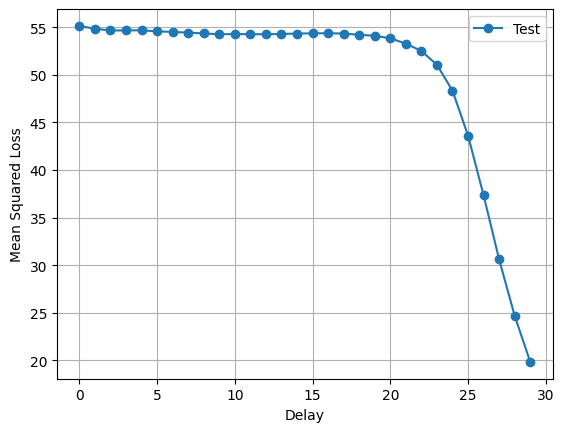

In [38]:

dtest = np.arange(0, dmax)

plt.plot(dtest,test_losses,'o-')
plt.xlabel('Delay')
plt.ylabel('Mean Squared Loss')
plt.grid()
plt.legend(['Test'],loc='upper right')

best_delay_index = np.argmin(test_losses)
print("Estimated best delay is {0:f} seconds (d = {1:d}) with a loss = {2:f}.".format(best_delay_index * 0.05, best_delay_index, np.min(test_losses)))

print(test_losses.shape)